### 1.0 Import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
import glob
import random

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

import xml.etree.ElementTree as ET 
import os

### 1.1 Set constant variables

In [2]:
np.random.seed(42) #Seeding
tf.random.set_seed(42)

train_img_path='train/' #Directory
test_img_path='test/'

apple_label=np.array([1,0,0,0]).reshape(1,4) #Label
banana_label=np.array([0,1,0,0]).reshape(1,4)
orange_label=np.array([0,0,1,0]).reshape(1,4)
mixed_label=np.array([0,0,0,1]).reshape(1,4)

### 2.0 Extract data from images

In [3]:
train_file_list=glob.glob(f'{train_img_path}*.jpg')
apple=[]
banana=[]
orange=[]
mixed=[]
for i in train_file_list:
    if i[6:11]=='apple':
        img=Image.open(i)
        apple.append(img)
    elif i[6:12]=='banana':
        img=Image.open(i)
        banana.append(img)
    elif i[6:12]=='orange':
        img=Image.open(i)
        orange.append(img)
    elif i[6:11]=='mixed':
        img=Image.open(i)
        mixed.append(img)

print(f"Apple: {len(apple)}")
print(f"Banana: {len(banana)}")
print(f"Orange: {len(orange)}")
print(f"Mixed fruits: {len(mixed)}")

Apple: 75
Banana: 73
Orange: 72
Mixed fruits: 20


### 2.1 Extract data from xml

In [4]:
train_xml = glob.glob('train/*.xml')
print(len(train_xml))
mixed_train_xml = [i for i in train_xml if 'mixed' in os.path.basename(i)]

240


In [5]:
# create path to save crop img if not exist
## Uncomment to save image 
# directory = 'cropped_image'
# if not os.path.exists(directory):
#     os.makedirs(directory)

apple2,banana2,orange2 = [],[],[]
for x in mixed_train_xml:
    filename = os.path.basename(x).split('.')[0]
    img = Image.open('train/'+filename+'.jpg')
    # Read xml
    tree = ET.parse(x)
    root = tree.getroot()
    objects = root.findall('object')
    bb = []
    count=0
    for obj in objects:
        class_name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        if class_name == 'apple':
            cropped_img = img.crop((xmin,ymin,xmax,ymax))
            apple2.append(cropped_img)
        if class_name == 'orange':
            cropped_img = img.crop((xmin,ymin,xmax,ymax))
            orange2.append(cropped_img)
        if class_name == 'banana':
            cropped_img = img.crop((xmin,ymin,xmax,ymax))
            banana2.append(cropped_img)
        count+=1
        # Uncomment to save image
#         rgb_cropped_img = cropped_img.convert('RGB')
#         rgb_cropped_img.save('cropped_image/'+filename+'_crop_'+class_name+'_'+str(count)+'.jpg')

### 2.2 Adding cropped image to original image

In [6]:
apple = apple+apple2
banana = banana+banana2
orange = orange+orange2
print(f"Apple: {len(apple)}")
print(f"Banana: {len(banana)}")
print(f"Orange: {len(orange)}")
print(f"Mixed fruits: {len(mixed)}")

Apple: 91
Banana: 101
Orange: 94
Mixed fruits: 20


### 2.3 Merge image function

In [7]:
def mergeImage(image_1,image_2,image_3):
    apple_resize=image_1.resize((128,128)) # resize image
    banana_resize=image_2.resize((128,128))
    orange_resize=image_3.resize((128,128))
    random_image_list=[apple_resize,banana_resize,orange_resize] #put images into a list
    random.shuffle(random_image_list) #shuffle the list
    new_image=Image.new('RGB',(256,256),(250,250,250)) 
    new_image.paste(random_image_list[0],(0,0))
    new_image.paste(random_image_list[1],(128,0))
    new_image.paste(random_image_list[2],(0,128))
    new_image.paste(random_image_list[0],(128,128))
    return new_image

### 2.4 Cleaning up images

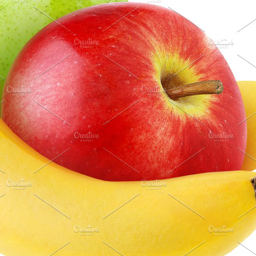

In [8]:
### Image is labelled as banana 
nk=79
apple[nk]=apple[nk].resize((256,256))
apple[nk]

Mixed fruit: 21


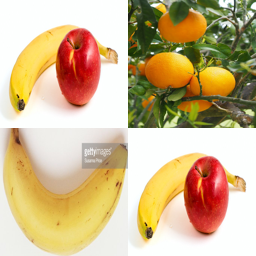

In [9]:
# Move it to mixed fruit
removed_image=banana.pop(54)
mixed.append(mergeImage(removed_image,orange[50],banana[95]))
print(f"Mixed fruit: {len(mixed)}")
mixed[20]

### 2.5 Generate images

In [10]:
# Generate to 100 images
# Apple 
for i in range(150-len(apple)):
    new_apple=mergeImage(apple[i],apple[i+7],apple[i+14])
    apple.append(new_apple)
# Banana
for i in range(150-len(banana)):
    new_banana=mergeImage(banana[i],banana[i+7],banana[i+14])
    banana.append(new_banana)
# Orange
for i in range(150-len(orange)):
    new_orange=mergeImage(orange[i],orange[i+7],orange[i+14])
    orange.append(new_orange)
# Mixed fruits
for i in range(150-len(mixed)):
    new_mixed=mergeImage(apple[i],banana[i],orange[i])
    mixed.append(new_mixed)
    
print(f"Apple: {len(apple)}")
print(f"Banana: {len(banana)}")
print(f"Orange: {len(orange)}")
print(f"Mixed fruits: {len(mixed)}")

C:\Users\gabri\anaconda3\envs\pythonEx\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Apple: 150
Banana: 150
Orange: 150
Mixed fruits: 150


### 2.6 Resizing the image

In [11]:
 def resize(list):
    train_images=None
    for image in list:
        train_img_resize=image.convert('RGB').resize((256,256))
        if train_images is None:
            train_images=train_img_resize
        else:
            train_images=np.concatenate((train_images,train_img_resize))
    train_images=train_images.reshape(-1,256,256,3)
    return train_images

apple=resize(apple)
print("Apple :",apple.shape)

banana=resize(banana)
print("Banana :",banana.shape)

orange=resize(orange)
print("Orange :",orange.shape)

mixed=resize(mixed)
print("Mixed :",mixed.shape)

Apple : (150, 256, 256, 3)
Banana : (150, 256, 256, 3)
Orange : (150, 256, 256, 3)
Mixed : (150, 256, 256, 3)


### 2.7 Image Augmentation

In [12]:
datagen=ImageDataGenerator(
        rotation_range=40, #Random rotation between 0 and 40
        channel_shift_range=150.0,
        brightness_range=(0.3,0.9),
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)

def imageAugmentation(fruit,number):
    i=1
    images=None
    for image in datagen.flow(fruit, batch_size=1): #fruit is in numpy array
        image=image.astype('uint8')
        if images is None:
            images=image
        else:
            images=np.concatenate((images,image))
        i+=1
        if i>number:
            break
    return images

apple_aug=imageAugmentation(apple,150)
banana_aug=imageAugmentation(banana,150)
orange_aug=imageAugmentation(orange,150)
mixed_aug=imageAugmentation(mixed,150)

Apple: (150, 256, 256, 3)
Banana: (150, 256, 256, 3)
Orange: (150, 256, 256, 3)
Mixed: (150, 256, 256, 3)


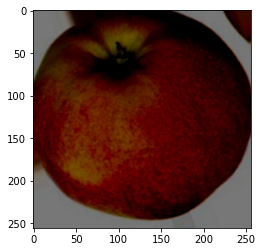

In [13]:
print("Apple:",apple_aug.shape)
print("Banana:",banana_aug.shape)
print("Orange:",orange_aug.shape)
print("Mixed:",mixed_aug.shape)

plt.imshow(apple_aug[4])

### 2.8 Combine all the image together

In [14]:
train_images=np.concatenate((apple,apple_aug,banana,banana_aug,orange,orange_aug,mixed,mixed_aug))
print("Total train image:", train_images.shape)

def genLabel():
    np_label=None
    for i in range(apple_aug.shape[0]+len(apple)):
        if np_label is None:
            np_label=apple_label
        else:
            np_label=np.concatenate((np_label,apple_label))
    for i in range(banana_aug.shape[0]+len(banana)):
        if np_label is None:
            np_label=banana_label
        else:
            np_label=np.concatenate((np_label,banana_label))
    for i in range(orange_aug.shape[0]+len(orange)):
        if np_label is None:
            np_label=orange_label
        else:
            np_label=np.concatenate((np_label,orange_label))
    for i in range(mixed_aug.shape[0]+len(mixed)):
        if np_label is None:
            np_label=mixed_label
        else:
            np_label=np.concatenate((np_label,mixed_label))
    return np_label

train_labels=genLabel()
print("Total train labels:",train_labels.shape)

Total train image: (1200, 256, 256, 3)
Total train labels: (1200, 4)



### 2.9 Reshuffle the test data sets

In [15]:
#train_images, train_labels = shuffle(train_images, train_labels,random_state=42)
#train_images.shape

### 3.0 Getting test images and labels

In [16]:
test_file_list=glob.glob(f'{test_img_path}*.jpg')
test_images=None
test_labels=[]
for i in test_file_list:
    if i[5:10]=='apple':
        img=Image.open(i).convert('RGB')
        img_resize=img.resize((256,256))
        test_labels.append([1,0,0,0])
        if test_images is None:
            test_images=img_resize
        else:
            test_images=np.concatenate((test_images,img_resize))              
    elif i[5:11]=='banana':
        img=Image.open(i).convert('RGB')
        img_resize=img.resize((256,256))
        test_labels.append([0,1,0,0])
        if test_images is None:
            test_images=img_resize
        else:
            test_images=np.concatenate((test_images,img_resize))
    elif i[5:11]=='orange':
        img=Image.open(i).convert('RGB')
        img_resize=img.resize((256,256))
        test_labels.append([0,0,1,0])
        if test_images is None:
            test_images=img_resize
        else:
            test_images=np.concatenate((test_images,img_resize))
    elif i[5:10]=='mixed':
        img=Image.open(i).convert('RGB')
        img_resize=img.resize((256,256))
        test_labels.append([0,0,0,1])
        if test_images is None:
            test_images=img_resize
        else:
            test_images=np.concatenate((test_images,img_resize))
test_images=test_images.reshape(-1,256,256,3)
test_labels=np.array(test_labels)
print(type(test_images))
print(type(test_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### 3.1 Normalized the data

In [17]:
train_images_norm=train_images/255
test_images_norm=test_images/255
print(train_images_norm.shape)
print(train_labels.shape)

(1200, 256, 256, 3)
(1200, 4)


### 4.0 Construct a model

In [18]:
 model = keras.Sequential([
            keras.Input(shape=(256,256,3)),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu",),
            layers.MaxPooling2D(pool_size=(2, 2)),

            layers.Conv2D(64, kernel_size=(3, 3), activation="relu",),
            layers.MaxPooling2D(pool_size=(2, 2)),
     
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu",),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.45),
     
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu",),
            layers.MaxPooling2D(pool_size=(2, 2)),
     
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu",),
            layers.MaxPooling2D(pool_size=(2, 2)),

            layers.Flatten(),
            layers.Dropout(0.45),
            layers.Dense(units=128, activation='relu'),
            layers.Dense(4, activation="softmax"),])

### 4.1 Specify hyper-parameters

In [19]:
model.compile(loss='categorical_crossentropy',
             optimizer=keras.optimizers.Adam(learning_rate=0.00146), #Setting the learning rate
             metrics=['accuracy'])

### 4.2 Train model

In [20]:
history = model.fit(train_images_norm, train_labels,validation_data=(test_images_norm, test_labels), epochs=20,batch_size=32)

Epoch 1/20
38/38 [==============================] - 41s 1s/step - loss: 1.1858 - accuracy: 0.4558 - val_loss: 0.9284 - val_accuracy: 0.6167
Epoch 2/20
38/38 [==============================] - 45s 1s/step - loss: 0.8718 - accuracy: 0.6208 - val_loss: 0.8319 - val_accuracy: 0.7000
Epoch 3/20
38/38 [==============================] - 39s 1s/step - loss: 0.7107 - accuracy: 0.6742 - val_loss: 0.9545 - val_accuracy: 0.7167
Epoch 4/20
38/38 [==============================] - 40s 1s/step - loss: 0.6448 - accuracy: 0.7167 - val_loss: 0.9154 - val_accuracy: 0.6833
Epoch 5/20
38/38 [==============================] - 42s 1s/step - loss: 0.5372 - accuracy: 0.7767 - val_loss: 0.5776 - val_accuracy: 0.8667
Epoch 6/20
38/38 [==============================] - 42s 1s/step - loss: 0.4077 - accuracy: 0.8467 - val_loss: 0.4563 - val_accuracy: 0.8833
Epoch 7/20
38/38 [==============================] - 43s 1s/step - loss: 0.3837 - accuracy: 0.8533 - val_loss: 0.4634 - val_accuracy: 0.9000
Epoch 8/20
38/38 [==

### 5.0 Evaluate model

In [21]:
loss, accuracy=model.evaluate(x=test_images_norm,y=test_labels)

print('loss = ',loss)
print('accuracy = ',accuracy)

2/2 [==============================] - 0s 215ms/step - loss: 0.3331 - accuracy: 0.9333
loss =  0.3330893814563751
accuracy =  0.9333333373069763


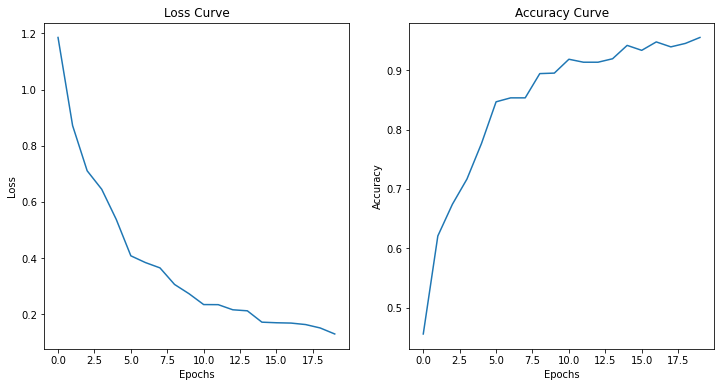

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax[0].plot(history.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Curve')

ax[1].plot(history.history['accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Curve')

plt.show()

### 5.1 Confusion matrix

<AxesSubplot:>

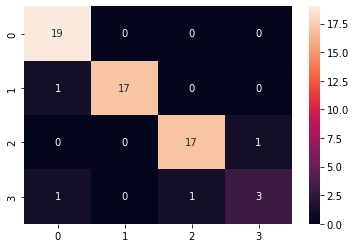

In [23]:
pred = model.predict(test_images_norm)
# matrix shows which class missed
matrix = confusion_matrix(test_labels.argmax(axis=1), pred.argmax(axis=1))
sns.heatmap(matrix, annot=True)

In [24]:
# Getting missed class image index 
#missed = np.nonzero(pred.argmax(axis=1) != test_labels.argmax(axis=1))

In [25]:
#plt.imshow(test_images[missed[0]])

### 6.0 Import to csv